# Testing the kinematic feature extraction code on Modelled Data

### Step 0: Make the modelled data
### Step 1: Plot and visualized what the expected results of modelled data are
### Step 2: Run the kinematic extraction code on the modelled data 
### Step 3: Plot the extracted kinematics for the modelled data
### Step 4: comapred the expectation and the results and make sure kinematic code works fine

In [1]:
%matplotlib inline

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from cv2 import VideoWriter, VideoWriter_fourcc
import pandas as pd
#import torch
from scipy import signal, ndimage, spatial
from scipy.signal import correlate
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter
import math 
#from signal_alignment import phase_align, chisqr_align
from scipy.interpolate import interp1d
import scipy.stats as stats
from scipy.stats import spearmanr
from plot_kinematics_basic import plot_kinematics 
from feature_eng import StrokeMetrics, ALSMetrics, ClinicalMetrics, ClinicalSignals

import get_onsets_basic

### Step 0: Make the modelled data

In [3]:
# CREATING A MODEL LOOKUP TABLE 
input_csv = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/Test_Table.csv"
out_path = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling"
csv_name = "model_lookup.csv"

model_lookup = pd.DataFrame()
from_example = pd.read_csv(input_csv)

try:
    from_example = from_example.drop(['Unnamed: 0'], axis=1)
    from_example.loc[0][['landmarks']] = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_BBP_NORMAL_landmarksFiltered3D.csv"
    from_example.loc[0][['landmarks_table']] = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_BBP_NORMAL_video.Table"
    from_example.loc[0][['rest']] = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_RST_REST_landmarksFiltered3D.csv"
except:
    pass


from_example.to_csv(os.path.join(out_path, csv_name))

In [4]:
# CREATING A MODEL Landmarks csv
input_csv = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/video_data/ALS/old/A001/landmarks_finetuned_w15/A001_02_NSM_OPEN_landmarksFiltered3D.csv"
out_path = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling"
csv_name = "NF000_02_BBP_NORMAL_landmarksFiltered3D.csv"


    

from_example = pd.read_csv(input_csv)
from_example = from_example.drop(['Unnamed: 0'], axis=1)
cols = from_example.columns
model_landmarks = pd.DataFrame(columns= cols)

new_cols=[]
for col in cols:
    if 'landmark' in col:
        new_cols.append(col)

            
model_landmarks['Video_Frame_number'] = np.array(range(100))
# sampling freq of 50 per second 
model_landmarks['Time_Stamp (s)'] = np.array(range(100))/50

# initialize all the landmark poses to zero 
model_landmarks[new_cols] = 0

# model the opening: which is based on using landmarks [51 and 57]

# initialize x and z components to 1, and 

model_landmarks['landmark_51'] = 1
model_landmarks['landmark_57'] = 1

model_landmarks['landmark_51.2'] = 1
model_landmarks['landmark_57.2'] = 1

model_landmarks['landmark_57.1'] = np.cos(np.linspace(-np.pi, 3*np.pi, 100))+2
model_landmarks['landmark_51.1'] = 1

# model the spread: which is based on using landmarks [48 and 54]

model_landmarks['landmark_48'] = 1
model_landmarks['landmark_54'] = np.cos(np.linspace(-np.pi, 3*np.pi, 100))+2

model_landmarks['landmark_48.1'] = 1
model_landmarks['landmark_54.1'] = 1

model_landmarks['landmark_48.2'] = 1
model_landmarks['landmark_54.2'] = 1


# model the distance from eye corners: which is based on using landmarks [42, 54], [39, 48]



# model the mouth left and right areas: which is based on using landmarks [48 and 54]
model_landmarks.to_csv(os.path.join(out_path, csv_name))


In [5]:
# CREATING A MODEL REST csv
input_csv = r"/Users/denizjafari/documents/CODE/ClinicalScore/FaceData_/video_data/ALS/old/A001/landmarks_finetuned_w15/A001_02_RST_REST_landmarksFiltered3D.csv"
out_path = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling"
csv_name = "NF000_02_RST_REST_landmarksFiltered3D.csv"


    

from_example = pd.read_csv(input_csv)
from_example = from_example.drop(['Unnamed: 0'], axis=1)
cols = from_example.columns
model_landmarks = pd.DataFrame(columns= cols)
model_landmarks['Video_Frame_number'] = np.array(range(100))
# sampling freq of 10 per second 
model_landmarks['Time_Stamp (s)'] = np.array(range(100))/10

new_cols=[]
for col in cols:
    if 'landmark' in col:
        new_cols.append(col)


# initialize all the landmark poses to zero 
model_landmarks[new_cols] = 1

model_landmarks.to_csv(os.path.join(out_path, csv_name))

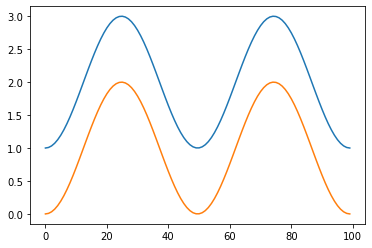

In [6]:
#x= np.array(range(100))* np.pi / 180.
x = np.linspace(-np.pi, 3*np.pi, 100)
plt.plot(np.cos(x)+2)
#plt.plot(x)



plt.plot(np.cos(np.linspace(-np.pi, 3*np.pi, 100))+2-1)

In [7]:
# Some helper functions

# Used to extract the patient type from the landmark file name
ids = {
    "stroke": ["OP", "S"],
    "healthy": ["N"],
    "als": ["A"]
}

# Defines which metric calculator to use based on the 'metric_type' argument
metric_calc_map = {
    "orofacial_features": ClinicalMetrics,
    "orofacial_signals": ClinicalSignals
}


def compute_metrics(inputs, out_path, metrics_type = 'orofacial_features'):
    """
    Computes the metrics for every file in the data csv
    :param inputs: A dataframe with columns: csv_path, rep_{}_start,
                                                       rep_{}_end
    :param out_path: A path to a csv to store the metric data in
    """
    # Key is task name and value is all repetitions of the task
    metric_frames: Dict[str, List[pd.DataFrame]] = {}
    for index, row in inputs.iterrows():
        # Read all data from the input dataframe
        try:
            data_path = row['csv_path']
            rest_path = row['rest_path']
            data_frame = pd.read_csv(data_path)
            rest_frame = pd.read_csv(rest_path)
            task_type = row['task']
            subject_id = row['subject']
            subject_type = row['type']
        except KeyError:
            raise KeyError("Input csv must contain 'csv_path', 'rest_path', 'rest_table_path' \
            'task', 'subject', and 'type' columns. \nFurthermore, 'csv_path' \
            and 'rest_path' must be files on the disk.")
        print("Starting:", data_path, "with", subject_type, "patients")
        rep_ranges = []
        rep_i = 1
        # Grab data about the start and end of repetitions
        while f"rep_{rep_i}_start" in row and f"rep_{rep_i}_end" in row:
            try:
                start_val = row[f"rep_{rep_i}_start"]
                end_val = row[f"rep_{rep_i}_end"]
                rep_ranges.append(range(int(start_val), int(end_val)))
            except ValueError as e:
                pass
            rep_i += 1
        rep_i -= 1

        # Calculate metrics
        metric_calc = metric_calc_map[metrics_type](data_frame, rest_frame)

        metric_frame = None
        for rep_range in rep_ranges:
            metrics = metric_calc.compute_metrics(active_frames=rep_range)
            print()
            print(metrics)
            print()
            if metric_frame is None:
                metric_frame = metrics
            else:
                metric_frame = pd.concat([metric_frame, metrics], ignore_index=True)
        rep_nums = list(range(1, rep_i+1))

        # Insert metadata to final csv
        metric_frame.insert(0, 'rep', pd.Series(rep_nums))
        metric_frame.insert(0, 'type', pd.Series(np.full(rep_i, int(not(subject_type == "healthy")))))
        metric_frame.insert(0, 'task', pd.Series(np.full(rep_i, task_type)))
        metric_frame.insert(0, 'subject_id', pd.Series(np.full(rep_i, subject_id)))
        try:
            metric_frames[task_type].append(metric_frame)
        except KeyError:
            metric_frames[task_type] = [metric_frame]

    # save data to disk
    for task, metrics in metric_frames.items():
        csv_name = "{}_metric_output_{}.csv".format(metrics_type,task)
        
        all_metrics_frame = pd.concat(metrics, ignore_index=True)

        
        if not os.path.exists(out_path):
            os.makedirs(out_path)
        all_metrics_frame.to_csv(os.path.join(out_path, csv_name))
        
    print(f"Saved metrics to {os.path.abspath(out_path)}")
    return metric_frames



def compute_signals(inputs, out_path, metrics_type = 'orofacial_signals'):
    """
    Computes the metrics for every file in the data csv
    :param inputs: A dataframe with columns: csv_path, rep_{}_start,
                                                       rep_{}_end
    :param out_path: A path to a csv to store the metric data in
    """
    # Key is task name and value is all repetitions of the task
    metric_frames: Dict[str, List[pd.DataFrame]] = {}
    for index, row in inputs.iterrows():
        # Read all data from the input dataframe
        try:
            data_path = row['csv_path']
            rest_path = row['rest_path']
            data_frame = pd.read_csv(data_path)
            rest_frame = pd.read_csv(rest_path)
            task_type = row['task']
            subject_id = row['subject']
            subject_type = row['type']
        except KeyError:
            raise KeyError("Input csv must contain 'csv_path', 'rest_path', 'rest_table_path' \
            'task', 'subject', and 'type' columns. \nFurthermore, 'csv_path' \
            and 'rest_path' must be files on the disk.")
        print("Starting:", data_path, "with", subject_type, "patients")
        rep_ranges = []
        rep_i = 1
        # Grab data about the start and end of repetitions
        while f"rep_{rep_i}_start" in row and f"rep_{rep_i}_end" in row:
            try:
                start_val = row[f"rep_{rep_i}_start"]
                end_val = row[f"rep_{rep_i}_end"]
                rep_ranges.append(range(int(start_val), int(end_val)))
            except ValueError as e:
                pass
            rep_i += 1
        rep_i -= 1

        # Calculate metrics
        metric_calc = metric_calc_map[metrics_type](data_frame, rest_frame)

        metric_frame = None
        
        for rep_range in rep_ranges:
            
            metrics = metric_calc.compute_metrics(active_frames=rep_range)
            
            metrics.insert(0, 'Time_Stamp', data_frame.loc[rep_range]['Time_Stamp (s)'].values)
            metrics.insert(0, 'type', pd.Series(np.full(len(metrics), int(not(subject_type == "healthy")))))
            metrics.insert(0, 'task', pd.Series(np.full(len(metrics), task_type)))
            metrics.insert(0, 'rep', pd.Series(np.full(len(metrics), rep_ranges.index(rep_range))))
            metrics.insert(0, 'subject_id', pd.Series(np.full(len(metrics), subject_id)))
            
            
            if metric_frame is None:
                metric_frame = metrics
            else:
                metric_frame = pd.concat([metric_frame, metrics], ignore_index=True)
      

        # Insert metadata to final csv
        
        
        
        try:
            metric_frames[task_type].append(metric_frame)
        except KeyError:
            metric_frames[task_type] = [metric_frame]

    # save data to disk
    for task, metrics in metric_frames.items():
        csv_name = "{}_metric_output_{}.csv".format(metrics_type,task)
        
        all_metrics_frame = pd.concat(metrics, ignore_index=True)

        
        if not os.path.exists(out_path):
            os.makedirs(out_path)
        all_metrics_frame.to_csv(os.path.join(out_path, csv_name))
        
    print(f"Saved metrics to {os.path.abspath(out_path)}")
    return metric_frames




In [8]:
def save_results(input_csv, output_folder, metric_type):
    analysis_csv = pd.DataFrame()
    files = pd.read_csv(input_csv)
    for i, row in files.iterrows():
        # Construct a dataframe with the information necessary for processing
        landmark_path = os.path.abspath(row["landmarks"])
        landmark_file_name = os.path.basename(landmark_path)
        table_path = os.path.abspath(row["landmarks_table"])
        table_file_name = os.path.basename(table_path)
        rest_path = os.path.abspath(row["rest"])
        rest_file_name = os.path.basename(table_path)
        print(landmark_path)
        print()
        print(rest_path)
        print()
        print(table_path)

        if not os.path.isfile(landmark_path):
            raise RuntimeError("Landmark path is not a file on disk")
        if not os.path.isfile(rest_path):
            raise RuntimeError("Rest file is not a file on disk")
        if not os.path.isfile(table_path):
            raise RuntimeError("Table file is not a file on disk")

        landmark_file_data = landmark_file_name.split("_")
        subject = landmark_file_data[0]
        subject_type = ""
        # Check if a user fits into a known subject type
        for s_type, prefixes in ids.items():
            for prefix in prefixes:
                if prefix in subject:
                    subject_type = s_type
        task = "_".join(landmark_file_data[2:4])
        parsed_data = pd.DataFrame(columns=["csv_path", "type", "rest_path", "subject", "task"])
        parsed_data.loc[0] = 0

        
     
        video_info = pd.read_csv(table_path)


        parsed_data["csv_path"] = landmark_path
        parsed_data["rest_path"] = rest_path
        parsed_data["type"] = subject_type
        parsed_data["subject"] = subject
        parsed_data["task"] = task
        for index, row in video_info.iterrows():
            parsed_data[f"rep_{index+1}_start"] = row[video_info.columns[0]]
            parsed_data[f"rep_{index+1}_end"] = row[video_info.columns[-1]] 
        analysis_csv = analysis_csv.append(parsed_data, ignore_index=True, sort=False)


    if metric_type == 'orofacial_signals':
        compute_signals(analysis_csv, output_folder,metric_type);
        
    else:
        compute_metrics(analysis_csv, output_folder,metric_type);

In [9]:
# Try with mini lookup table of 1 modelled data

metric_type = 'orofacial_signals' 

 #csv file with modelled fake landmarks info and the made up .TABLE info
input_csv = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/model_lookup.csv"
#where to store the results
output_folder = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling" 
save_results(input_csv, output_folder, metric_type)




/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_BBP_NORMAL_landmarksFiltered3D.csv

/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_RST_REST_landmarksFiltered3D.csv

/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_BBP_NORMAL_video.Table
Starting: /Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_BBP_NORMAL_landmarksFiltered3D.csv with healthy patients
active features in eval_feature
[0.0320513  0.0320513  0.07163207 0.12615062 0.19472974 0.27626596
 0.36944733 0.47277453 0.58458499 0.70307962 0.82635182 0.95241808
 1.07924996 1.20480667 1.32706796 1.44406661 1.55392006 1.65486073
 1.74526445 1.82367658 1.88883545 1.93969262 1.97542979 1.98743889
 1.98743889 1.98743889 1.95949297 1.91610846 1.85798341 1.78605309
 1.70147489 1.60560969 1.5        1.38634513 1.26647381 1.14231484
 1.01586596 0.8891618  0.76424106 0.64311378 0.52772893 0.41994309
 0.

/Users/denizjafari/Documents/CODE/ClinicalScore/ClinicalScore/feature_eng.py:400: RuntimeWarning: invalid value encountered in true_divide
  z_scores = (feature - mean) / sd


active features in eval_feature
[0.0320513  0.0320513  0.07163207 0.12615062 0.19472974 0.27626596
 0.36944733 0.47277453 0.58458499 0.70307962 0.82635182 0.95241808
 1.07924996 1.20480667 1.32706796 1.44406661 1.55392006 1.65486073
 1.74526445 1.82367658 1.88883545 1.93969262 1.97542979 1.98743889
 1.98743889 1.98743889 1.95949297 1.91610846 1.85798341 1.78605309
 1.70147489 1.60560969 1.5        1.38634513 1.26647381 1.14231484
 1.01586596 0.8891618  0.76424106 0.64311378 0.52772893 0.41994309
 0.32149059 0.23395556 0.15874647 0.09707346 0.04992888 0.0180713
 0.0180713  0.0180713  0.0180713  0.04992888 0.09707346 0.15874647
 0.23395556 0.32149059 0.41994309 0.52772893 0.64311378 0.76424106
 0.8891618  1.01586596 1.14231484 1.26647381 1.38634513 1.5
 1.60560969 1.70147489 1.78605309 1.85798341 1.91610846 1.95949297
 1.98743889 1.98743889 1.98743889 1.97542979 1.93969262 1.88883545
 1.82367658 1.74526445 1.65486073 1.55392006 1.44406661 1.32706796
 1.20480667 1.07924996 0.95241808 0.82

In [11]:
metric_type = 'orofacial_features' 

 #csv file with modelled fake landmarks info and the made up .TABLE info
input_csv = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/model_lookup.csv"
#where to store the results
output_folder = r"/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling"
save_results(input_csv, output_folder, metric_type)


/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_BBP_NORMAL_landmarksFiltered3D.csv

/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_RST_REST_landmarksFiltered3D.csv

/Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_BBP_NORMAL_video.Table
Starting: /Users/denizjafari/documents/CODE/ClinicalScore/ClinicalScore/DataModeling/NF000_02_BBP_NORMAL_landmarksFiltered3D.csv with healthy patients
I came here
active features in eval_feature
[0.0320513  0.0320513  0.07163207 0.12615062 0.19472974 0.27626596
 0.36944733 0.47277453 0.58458499 0.70307962 0.82635182 0.95241808
 1.07924996 1.20480667 1.32706796 1.44406661 1.55392006 1.65486073
 1.74526445 1.82367658 1.88883545 1.93969262 1.97542979 1.98743889
 1.98743889 1.98743889 1.95949297 1.91610846 1.85798341 1.78605309
 1.70147489 1.60560969 1.5        1.38634513 1.26647381 1.14231484
 1.01586596 0.8891618  0.76424106 0.64311378 0.52772893 0.

/Users/denizjafari/Documents/CODE/ClinicalScore/ClinicalScore/feature_eng.py:400: RuntimeWarning: invalid value encountered in true_divide
  z_scores = (feature - mean) / sd
//anaconda3/envs/ClinicalScore36/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
//anaconda3/envs/ClinicalScore36/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/denizjafari/Documents/CODE/ClinicalScore/ClinicalScore/feature_eng.py:241: RuntimeWarning: invalid value encountered in double_scalars
  p = (2 * s1s2) / (s1_ss2 + s2_ss2 + (m_s1 - m_s2)**2)
/Users/denizjafari/Documents/CODE/ClinicalScore/ClinicalScore/feature_eng.py:701: RuntimeWarning: invalid value encountered in double_scalars
  R_RALA = rA_AVG /lA_AVG


active features in eval_feature
[1.75075123 1.75075123 1.7743718  1.80782057 1.85131822 1.90495533
 1.96860001 2.04182879 2.1238902  2.21370283 2.30988333 2.4107958
 2.51461337 2.61938398 2.7230948  2.82373186 2.91933343 3.00803682
 3.08811867 3.15802936 3.21642196 3.26217607 3.29441686 3.30526718
 3.30526718 3.30526718 3.28003028 3.24093945 3.188741   3.12443464
 3.04925672 2.96465881 2.87228132 2.77392196 2.67149837 2.56700465
 2.46246129 2.35985854 2.2610941  2.16790749 2.08181547 2.00405548
 1.93554576 1.87687142 1.82830341 1.789852   1.7613491  1.74254675
 1.74254675 1.74254675 1.74254675 1.7613491  1.789852   1.82830341
 1.87687142 1.93554576 2.00405548 2.08181547 2.16790749 2.2610941
 2.35985854 2.46246129 2.56700465 2.67149837 2.77392196 2.87228132
 2.96465881 3.04925672 3.12443464 3.188741   3.24093945 3.28003028
 3.30526718 3.30526718 3.30526718 3.29441686 3.26217607 3.21642196
 3.15802936 3.08811867 3.00803682 2.91933343 2.82373186 2.7230948
 2.61938398 2.51461337 2.4107958 

active features in eval_feature
[1.75075123 1.75075123 1.7743718  1.80782057 1.85131822 1.90495533
 1.96860001 2.04182879 2.1238902  2.21370283 2.30988333 2.4107958
 2.51461337 2.61938398 2.7230948  2.82373186 2.91933343 3.00803682
 3.08811867 3.15802936 3.21642196 3.26217607 3.29441686 3.30526718
 3.30526718 3.30526718 3.28003028 3.24093945 3.188741   3.12443464
 3.04925672 2.96465881 2.87228132 2.77392196 2.67149837 2.56700465
 2.46246129 2.35985854 2.2610941  2.16790749 2.08181547 2.00405548
 1.93554576 1.87687142 1.82830341 1.789852   1.7613491  1.74254675
 1.74254675 1.74254675 1.74254675 1.7613491  1.789852   1.82830341
 1.87687142 1.93554576 2.00405548 2.08181547 2.16790749 2.2610941
 2.35985854 2.46246129 2.56700465 2.67149837 2.77392196 2.87228132
 2.96465881 3.04925672 3.12443464 3.188741   3.24093945 3.28003028
 3.30526718 3.30526718 3.30526718 3.29441686 3.26217607 3.21642196
 3.15802936 3.08811867 3.00803682 2.91933343 2.82373186 2.7230948
 2.61938398 2.51461337 2.4107958 

/Users/denizjafari/Documents/CODE/ClinicalScore/ClinicalScore/feature_eng.py:400: RuntimeWarning: invalid value encountered in true_divide
  z_scores = (feature - mean) / sd
//anaconda3/envs/ClinicalScore36/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
//anaconda3/envs/ClinicalScore36/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/denizjafari/Documents/CODE/ClinicalScore/ClinicalScore/feature_eng.py:241: RuntimeWarning: invalid value encountered in double_scalars
  p = (2 * s1s2) / (s1_ss2 + s2_ss2 + (m_s1 - m_s2)**2)
/Users/denizjafari/Documents/CODE/ClinicalScore/ClinicalScore/feature_eng.py:701: RuntimeWarning: invalid value encountered in double_scalars
  R_RALA = rA_AVG /lA_AVG
